In [1]:
# This is the script for filtering tracks that are in vicinity of China Mainland (<500 km of coastline).
# Input file: CMA best track -- CMA_Best_Tracks_Nodes.shp,  
#             China border shape file -- '/home/lzhou/GIS/China_Border/CHN_adm0.shp'
# Output Dir: /home/lzhou/Precipitation/Precipitation_Scripts/Output
# Outfile: CMA_500km_tracks.shp

In [2]:
import os
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point, Polygon
import geopandas as gpd
from pyproj import CRS
import seaborn as sns
import matplotlib.pyplot as plt

# Make some of the spatial queries running faster
from shapely import speedups
import shapely
speedups.enabled

True

In [3]:
# load the best track shape file
zone=1000000 #500km around tracks
indir = '/home/lzhou/Precipitation/Precipitation_Scripts/Output/'
#indir = r'D:\GitHub\Precipitation_Scripts\Output'
nodes = gpd.read_file(os.path.join(indir,'CMA_Best_Tracks_Nodes.shp'))
tracks = gpd.read_file(os.path.join(indir,'CMA_Best_Tracks.shp'))

In [4]:
# get China shape file
#shapefile = '/home/lzhou/GIS/china-shapefiles-master/ne_10m_coastline.shp'
#shapefile = '/home/lzhou/GIS/China_Border/CHN_adm0.shp'
#cn_shape = gpd.read_file(shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cn_shape = world[world.name=='China'].copy()
cn_shape.reset_index(drop=True,inplace=True)

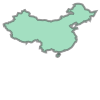

In [5]:
cn_shape.loc[0,'geometry']

In [6]:
# filter out nodes that are on land
test1 = nodes.geometry.apply(lambda x: x.within(cn_shape.loc[0,'geometry']))
nodes_onland = nodes[test1].copy()
nodes_onland.to_file(os.path.join(indir,'CMA_Tracks_Nodes_on_Land.shp'))


In [7]:
# filter out tracks that are on land
test0 = tracks.geometry.apply(lambda x: x.intersects(cn_shape.loc[0,'geometry']))
tracks_onland = tracks[test0].copy()
tracks_onland.to_file(os.path.join(indir,'CMA_Tracks_on_Land.shp'))

<AxesSubplot:>

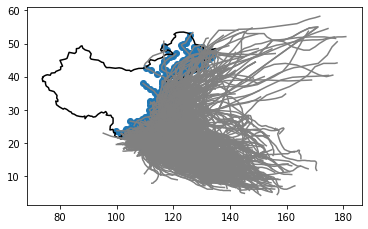

In [8]:
#plot to check
m=nodes_onland.plot()
cn_shape.boundary.plot(ax=m,color='black')
tracks_onland.plot(ax=m,color='grey')
#buffer.boundary.plot(ax=m,color='red')


In [9]:
%%time
# Filter out nodes from all years 

# reproject shapes to a projected crs
proj_epsg = 2345 # Xian 114-120 degree
cn_shape = cn_shape.to_crs(epsg=proj_epsg)

# since buffering cn_shape takes forever, get a envelope around the shape for approximation
envelope = cn_shape['geometry'].convex_hull
buffer = envelope.buffer(zone)

#type(buffer.loc[0])
buffer_wgs = buffer.to_crs(epsg=4326)
buffer_wgs.bounds


CPU times: user 114 ms, sys: 5.2 ms, total: 120 ms
Wall time: 118 ms


,minx,miny,maxx,maxy
0,64.137698,9.232507,148.092006,62.38418


<AxesSubplot:>

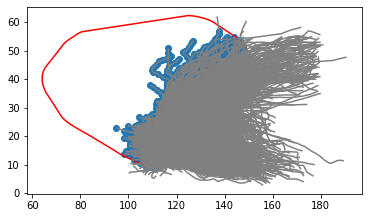

In [10]:
#plot to check
#test0 = tracks.geometry.apply(lambda x: x.intersects(cn_shape.loc[0,'geometry']))
test2 = tracks.geometry.apply(lambda x: x.intersects(buffer_wgs.loc[0]))
tracks_500km = tracks[test2].copy()


test3 = nodes.geometry.apply(lambda x: x.within(buffer_wgs.loc[0]))
nodes_500km = nodes[test3].copy()

m=nodes_500km.plot()
buffer_wgs.boundary.plot(ax=m,color='red')
tracks_500km.plot(ax=m,color='grey')



In [11]:
# save the filtered nodes and results
tracks_500km.reset_index(drop=True,inplace=True)
nodes_500km.reset_index(drop=True,inplace=True)
tfile = 'CMA_Tracks_'+str(int(zone/1000))+'km.shp'
nfile = 'CMA_Tracks_Nodes_' + str(int(zone/1000))+'km.shp'
tracks_500km.to_file(os.path.join(indir,tfile))
nodes_500km.to_file(os.path.join(indir,nfile))
